### 0. Import util libraries


In [38]:
import xarray as xr
import numpy as np
from matplotlib import rc

from inversion_sst_gp import (
    plot_helper,
    utils,
    other_methods,
    metrics,
    gp_regression,
)

rc("font", family="serif", serif=["Computer Modern"])
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{amsmath}")

In [39]:
# Plotting parameters
lonlims = (115, 118)
latlims = (-15.5, -12.5)

### 1. Fully observed noiseless experiment - single instance


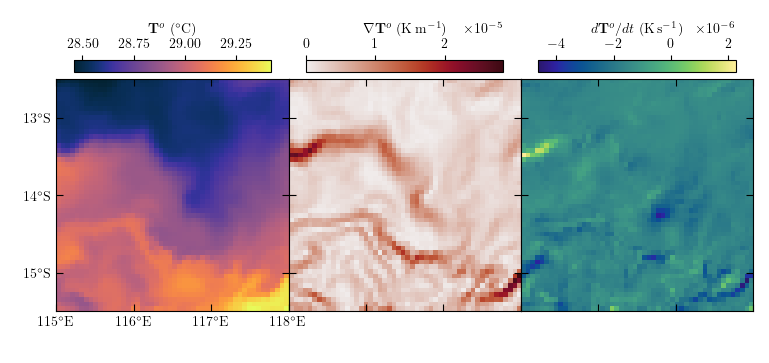

In [40]:
# Load dataset
ds = xr.open_dataset("1_preproc_data/proc_data/suntans_1h.nc").sel(
    time=np.datetime64("2014-02-19T18:00:00")
)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [41]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/noise_gp_obs_t.csv",
    "noise_sd",
    0,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)

metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.04687
rho_mag    : 0.8764
phi        : -3.612
crps_norm  : 0.02662
coverage90 : 0.8424


In [42]:
# Global optimal solution
n_gos = int(
    utils.extract_params(
        "2_covariance_parameter_estimation/outputs/noise_gos_t.csv",
        "noise_sd",
        0,
        type="gos",
    )["n"]
)
ugos, vgos, Sgos = other_methods.calculate_prediction_gos(dTds1o, dTds2o, dTdto, n_gos)
metrics_gos = metrics.overview(u, v, ugos, vgos, print_bool=True)

RMSE       : 0.07383
rho_mag    : 0.7304
phi        : -1.714


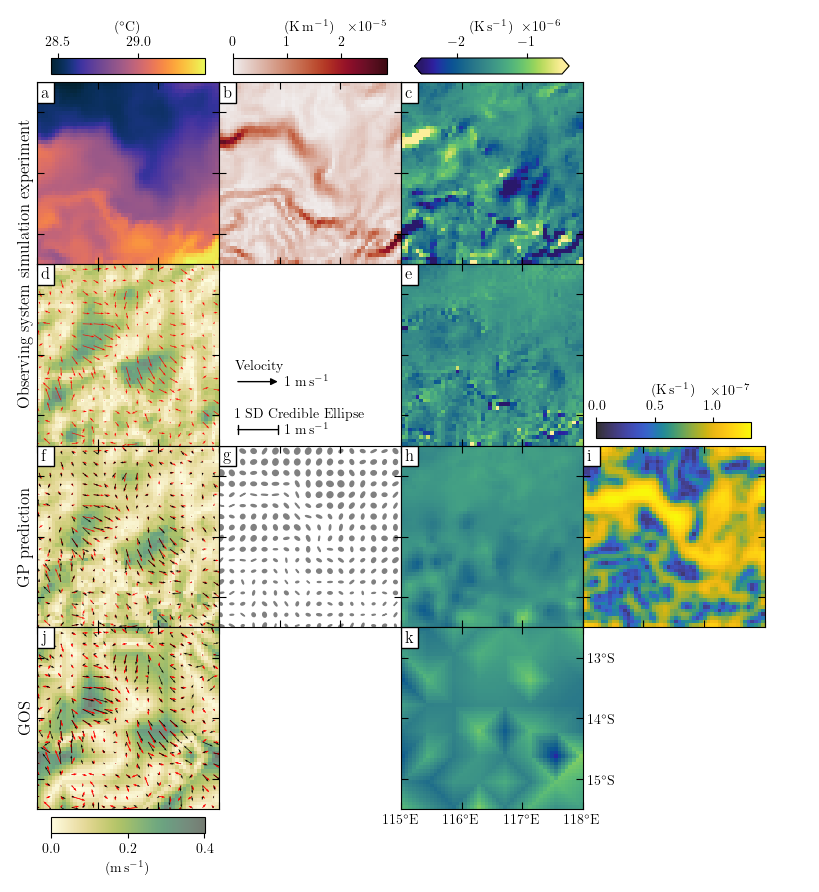

In [43]:
# Plot predictions
fig, ax = plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    ugos=ugos,
    vgos=vgos,
    Sgos=Sgos,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
    return_fig=True,
)
fig.savefig(
    "3_observing_system_simulation_experiment/figures/osse_instance_fully_observed.png",
    bbox_inches="tight",
    dpi=300,
)

In [44]:
# Store transect data
transect_fully_observed = {
    "lon": lon,
    "maskc": np.isnan(To[25, :]),
    "v": v[25, :],
    "muvstar": muvstar[25, :],
    "stdvstar": stdvstar[25, :],
}

### 2. Measurement error experiment - single noise level


In [45]:
xr.open_dataset("1_preproc_data/proc_data/suntans_measurement_error.nc")

<xarray.Dataset> Size: 2MB
Dimensions:    (sigma_tau: 16, lat: 50, lon: 50)
Coordinates:
  * sigma_tau  (sigma_tau) float64 128B 0.0 0.001 0.002 ... 0.013 0.014 0.015
    time_step  int64 8B ...
  * lat        (lat) float64 400B -15.47 -15.41 -15.35 ... -12.65 -12.59 -12.53
  * lon        (lon) float64 400B 115.0 115.1 115.2 115.2 ... 117.8 117.9 118.0
    time       datetime64[ns] 8B ...
Data variables:
    T          (sigma_tau, lat, lon) float64 320kB ...
    dTdt       (sigma_tau, lat, lon) float64 320kB ...
    u          (sigma_tau, lat, lon) float64 320kB ...
    v          (sigma_tau, lat, lon) float64 320kB ...
    S          (sigma_tau, lat, lon) float64 320kB ...

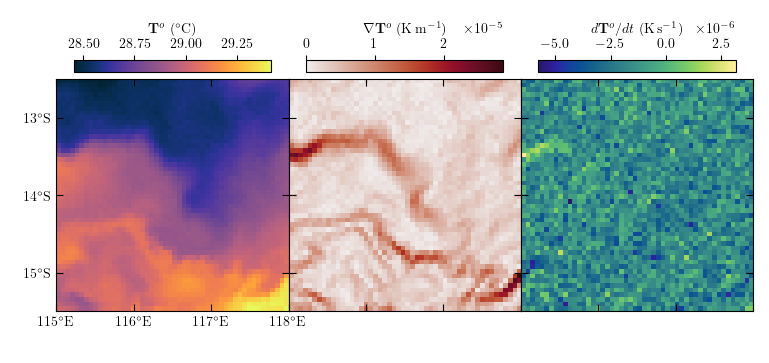

In [46]:
# Load dataset
noise = 0.005
ds = xr.open_dataset("1_preproc_data/proc_data/suntans_measurement_error.nc").sel(
    sigma_tau=noise
)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [47]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/noise_gp_obs_t.csv",
    "noise_sd",
    noise,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.07049
rho_mag    : 0.6905
phi        : -6.262
crps_norm  : 0.03989
coverage90 : 0.857


In [48]:
# Global optimal solution
n_gos = int(
    utils.extract_params(
        "2_covariance_parameter_estimation/outputs/noise_gos_t.csv",
        "noise_sd",
        noise,
        type="gos",
    )["n"]
)
ugos, vgos, Sgos = other_methods.calculate_prediction_gos(dTds1o, dTds2o, dTdto, n_gos)
metrics_gos = metrics.overview(u, v, ugos, vgos, print_bool=True)

RMSE       : 0.09402
rho_mag    : 0.4119
phi        : -8.94


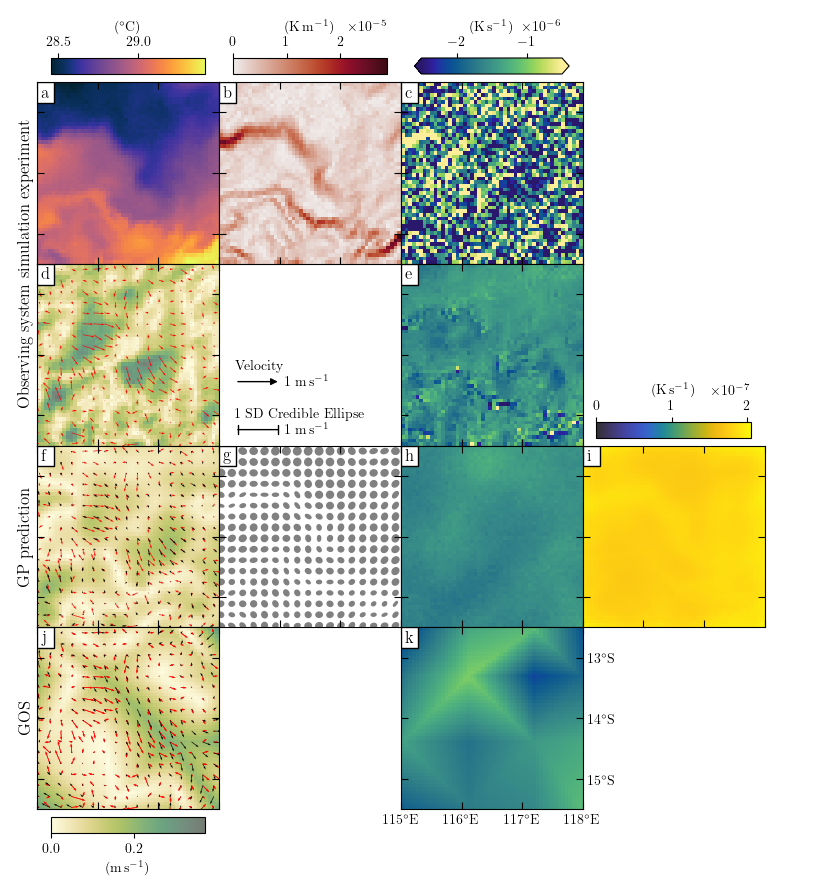

In [49]:
# Plot predictions
fig, ax = plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    ugos=ugos,
    vgos=vgos,
    Sgos=Sgos,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
    return_fig=True,
)
fig.savefig(
    "3_observing_system_simulation_experiment/figures/osse_instance_noise.png",
    bbox_inches="tight",
    dpi=300,
)

In [50]:
# Store transect data
transect_measurement_error = {
    "lon": lon,
    "maskc": np.isnan(To[25, :]),
    "v": v[25, :],
    "muvstar": muvstar[25, :],
    "stdvstar": stdvstar[25, :],
}

### 3. Dense cloud experiment


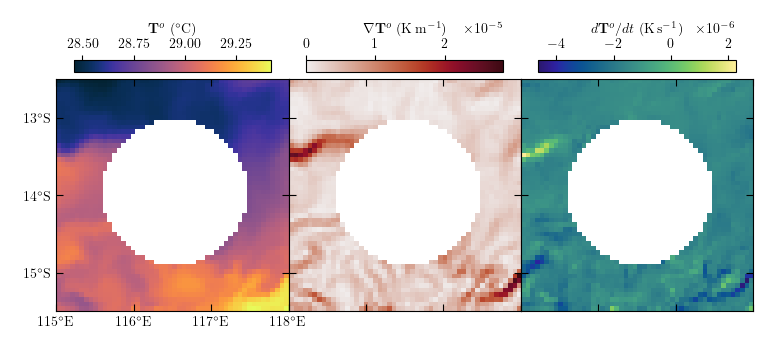

In [51]:
# Load dataset
coverage_dense = 0.3
ds = xr.open_dataset("1_preproc_data/proc_data/suntans_dense_cloud.nc").sel(
    coverage_dense=coverage_dense
)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [52]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/cloud_dense_gp_obs_t.csv",
    "coverage_dense",
    coverage_dense,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.07035
rho_mag    : 0.6901
phi        : -6.366
crps_norm  : 0.03753
coverage90 : 0.8434


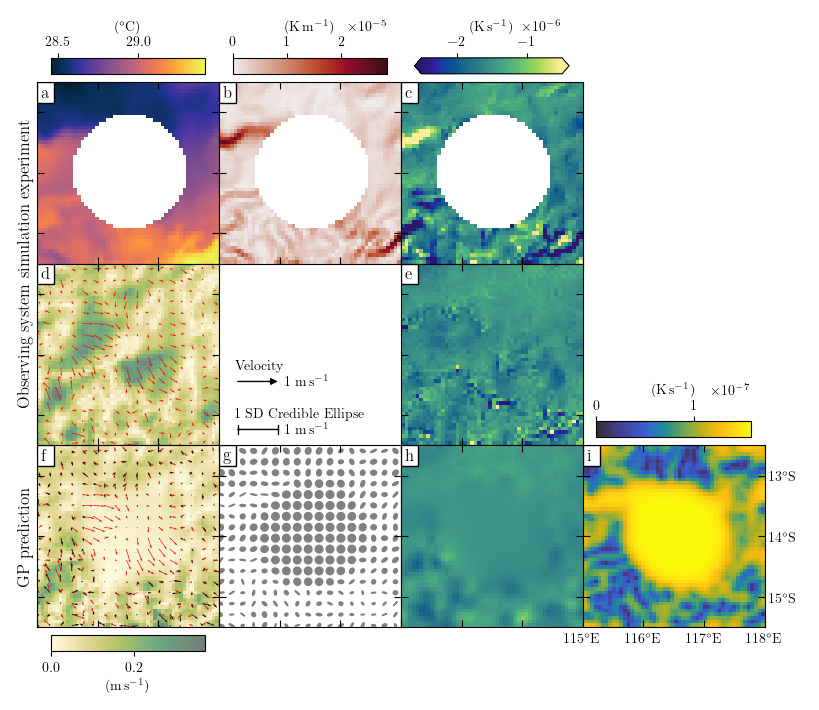

In [53]:
# Plot predictions
fig, ax =plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
    return_fig=True,
)
fig.savefig(
    "3_observing_system_simulation_experiment/figures/osse_instance_dense_cloud.png",
    bbox_inches="tight",
    dpi=300,
)

In [54]:
# Store transect data
transect_dense_cloud = {
    "lon": lon,
    "maskc": np.isnan(To[25, :]),
    "v": v[25, :],
    "muvstar": muvstar[25, :],
    "stdvstar": stdvstar[25, :],
}

### 4. Sparse cloud experiment


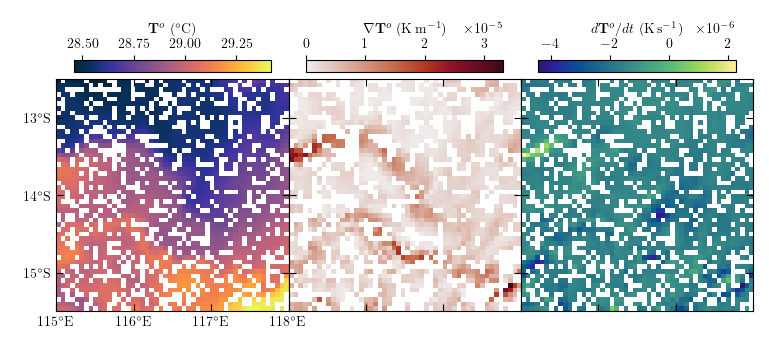

In [55]:
# Load dataset
coverage_sparse = 0.3
ds = xr.open_dataset("1_preproc_data/proc_data/suntans_sparse_cloud.nc").sel(
    coverage_sparse=coverage_sparse
)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [56]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/cloud_sparse_gp_obs_t.csv",
    "coverage_sparse",
    coverage_sparse,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.06764
rho_mag    : 0.7298
phi        : -2.762
crps_norm  : 0.03822
coverage90 : 0.7726


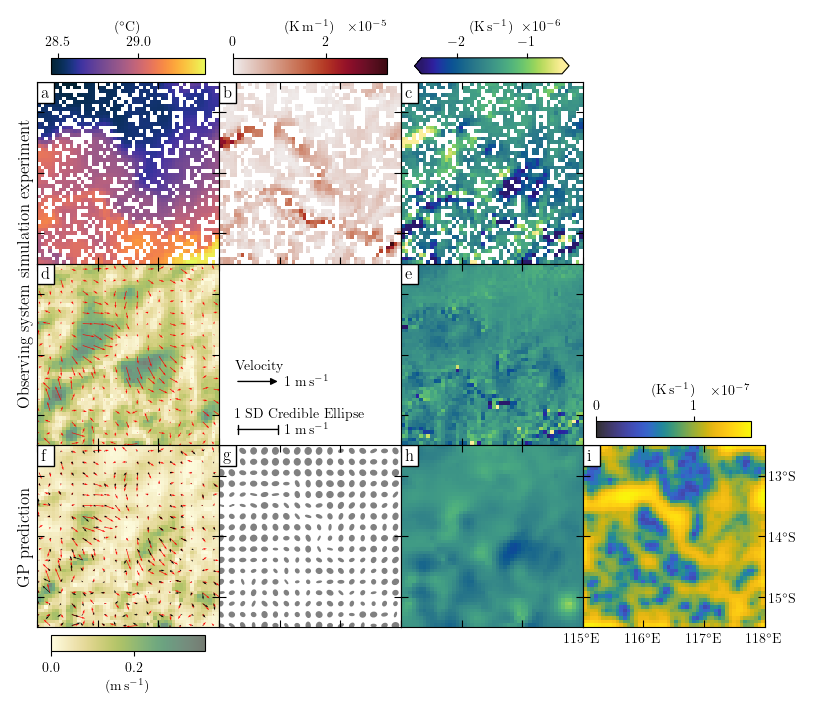

In [57]:
# Plot predictions
fig, ax = plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
    return_fig=True,
)
fig.savefig(
    "3_observing_system_simulation_experiment/figures/osse_instance_sparse_cloud.png",
    bbox_inches="tight",
    dpi=300,
)

In [58]:
# Store transect data
transect_sparse_cloud = {
    "lon": lon,
    "maskc": np.isnan(To[25, :]),
    "v": v[25, :],
    "muvstar": muvstar[25, :],
    "stdvstar": stdvstar[25, :],
}

### 5. Combine transects of experiments


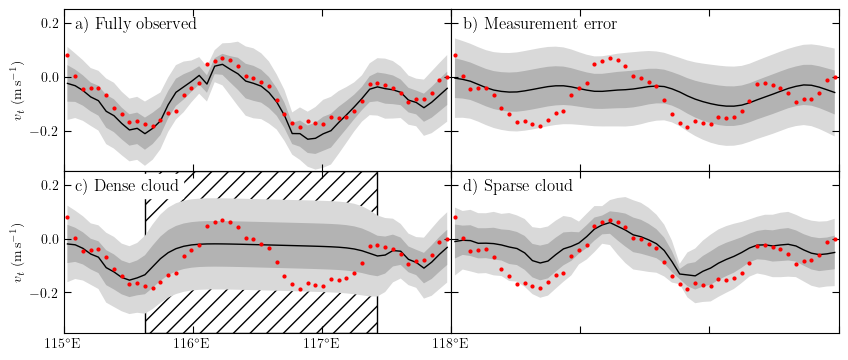

In [59]:
fig, ax = plot_helper.plot_transects(
    transect_fully_observed,
    transect_measurement_error,
    transect_dense_cloud,
    transect_sparse_cloud,
    lonlims,
    [-0.35, 0.25],
    return_fig=True,
)
fig.savefig(
    "3_observing_system_simulation_experiment/figures/osse_instance_overview_transect.png",
    bbox_inches="tight",
    dpi=300,
)